In [1]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import random

from os import listdir
from os.path import isfile, join

plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson

import epyestim
import epyestim.covid19 as covid19
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import geojson
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from xgboost import XGBRegressor, DMatrix, train
from sklearn.multioutput import MultiOutputRegressor

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pykalman import KalmanFilter

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping
from PIL import Image

import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
map_token='pk.eyJ1IjoiZnJhbmNpZ2plY2kiLCJhIjoiY2tpazZveWhmMDZ5MzMxcWp4bzIxbm0wYyJ9.J_qWOJqADI6tZfle2bbZFg'

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from functools import partial


to_sum_KPIs = ['totale_casi_giornalieri', 'terapia_intensiva_giornalieri', 'terapia_intensiva', 'nuovi_positivi', 'tamponi_giornalieri']
covidKPIsPrecompute = ['%pos']+to_sum_KPIs
trafficKPIsPrecompute = ['Handover', 'Download vol.', 'Upload vol.', '#Users']

def map_geojson(region):
    regions_map = {"Valle d'Aosta/Vallée d'Aoste": 'Valle d\'Aosta', "Trentino-Alto Adige/Südtirol": 'Trentino-Alto Adige',\
                  "Friuli-Venezia Giulia": "Friuli Venezia Giulia", "Emilia-Romagna": "Emilia Romagna"}
    return regions_map[region]

def plotly_fig2img(fig):
    #convert Plotly fig to  an array
    fig_bytes = fig.to_image(format="png")
    buf = io.BytesIO(fig_bytes)
    img = Image.open(buf)
    return img

data_path = "/Users/filipkrasniqi/Documents/Datasets.tmp/traffic-covid/"
by_region_path = "{}By_Region/".format(data_path)
saved = "{}saved/".format(data_path)
traffic_daily = "{}TS_1800_daily.pkl".format(saved)
region_traffic_daily = "{}all.pkl".format(saved)
covid = "{}covid/".format(data_path)
covid_daily = "{}covid_regioni.csv".format(covid)

## Introduction
The expected reproduction number Rt is a statistical measure that estimates the average number of people that a person, infected at time t, can infect. At time t, different approaches are used to compute such a value (Wallinga-Teunis, 2004; Bettencourd Ribeiro, 2008; Cori et al., 2013 (EpiEstim, our approach: https://academic.oup.com/aje/article/178/9/1505/89262?login=true)). In the COVID-19 pandemic, the Rt number computed in a specific area is used to explain how much COVID-19 is spreaded in that area; for this reason, it is an important measure to assess the restrictions to adopt. In Italy, for example, restrictions are applied per region; every two weeks, as the pandemic evolvs, restrictions are updated per region by evaluating different parameters, including the Rt value, that has a high relevant. A model able to forecast the Rt would provide an important asset to the government, as it would be able to prevent critical situations for the health system.

From a statistical point of view, to forecast the next step value of Rt (i.e., Rt+1), we'd need to know the current Rt value, and a mobility measure. For example, if we have, at day t, Rt=1, but mobility is really low, Rt+1 will change slightly from Rt; instead, with the same value of Rt but much higher mobility, Rt+1 will surely increase.

## Goal
Based on the previous example, it should be now clear why our goal is to learn a model that is able to forecast the Rt value, given mobile traffic and mobility features together with previous values of Rt itself. In particular, we won't focus on a single step prediction (i.e., one day later), but we'll consider a multi-step prediction. To achieve a farsightness of T, we'll build T models:

$$\forall{k} \in{1, ..., T}$$ $$\hat{Y}_{t+k}=f(X_{t-T_{F}:t-1}, Y_{t-T_{F}:t-1})$$

For this reason, our case falls in the category of multi-step forecasting with multivariate input data. Our goal is twofold:
- find a suitable model that is able to predict as farsighted as he can, while providing a certain level of guarantee that such a result will be reliable
- compare different ML techniques, involving a DL model

# Dataset

## COVID-19
The Italian COVID-19 dataset we are using is the one provided by the "Protezione Civile" (https://github.com/pcm-dpc/COVID-19). The higher achievable granularity is per province; in our study, we'll consider regional timeseries regarding intensive care units, new positive cases (with the percentage wrt the daily PCR tests, that, instead, cannot be known per province) and other information. For the purpose of our article, only new positive cases are considered, as they are the only information we'll need to compute the effective reproduction number Rt. Such a number was not available, and we used epyestim library to compute it.

### Import

In [2]:
path_covid_predictions="{}predictions/covid.pkl".format(saved)
df_covid_predictions = pd.read_pickle(path_covid_predictions)
regions = df_covid_predictions.index.get_level_values('Regione').unique()

## Traffic
Our traffic dataset has a much higher granularity when compared to the COVID one. We have hourly data per cell tower. For our purpose, we'll group it per region, in order to have the same granularity as the COVID-19. Please note that a further analysis could be done with the same data but per province. From our analysis of the data, given a region, we got that the features that highly affect Rt are:
- per-region daily amount of downloaded traffic
- per-region daily amount of uploaded traffic
- per-region daily amount of number of users that at least once were connected to the tower during the day
- per-region daily handover success, i.e., number of times devices connected to the tower when switching from one cell tower to another

All these features have been aggregated for each region r and for day d by simply summing up all the values of the corresponding feature during the day for all the cells belonging to region r. As we'll see, these data happen to be pretty noisy; one could see visible oscillation, in particular during the week. This affects the learning phase, thus we applied a Kalman Filter to smoothen the feature.

### Import

In [3]:
path_traffic_predictions="{}predictions/traffic.pkl".format(saved)
df_traffic_predictions = pd.read_pickle(path_traffic_predictions)
# x1, ..., xN
# x1, ..., XN-R

## Visualize

### Timeseries

In [6]:
divider_po, divider_so = pd.to_datetime('2020-08-01'), pd.to_datetime('2020-10-01')

region = "Veneto"
trafficKPI="Handover"
trafficKPI2="Handover_MA"
covidKPI = "R_mean"

name = "Timeseries"

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Set x-axis title
fig.update_xaxes(title_text="Day")

# Set y-axes titles
fig.update_yaxes(title_text=trafficKPI, secondary_y=False)
fig.update_yaxes(title_text=covidKPI, secondary_y=True)

traffic_colors = ['#FF0000', '#f56342', '#f57e42', '#f59642', '#f5a742']
covid_colors = ['#0000FF', '#0062ff', '#008cff', '#00b3ff', '#00b7e0']

def filter_fun(df):
    return (df['Date'] >= start_date) & (df['Date'] <= end_date)

df_traffic_region = df_traffic_predictions.xs(region, level='Regione')
df_covid_region = df_covid_predictions.xs(region, level='Regione')

#df_traffic_region_po, df_traffic_region_so = df_traffic_region.loc[:divider_po], df_traffic_region.loc[divider_so:]
df_covid_region_po, df_covid_region_so = df_covid_region.loc[:divider_po], df_covid_region.loc[divider_so:]

def normalize(series):
    return series.transform(lambda x: (x-x.mean())/x.std(ddof=1))

series_1 = normalize(df_traffic_region[trafficKPI])
series_2 = normalize(df_traffic_region[trafficKPI2])
po_series_1, so_series_1 = series_1.loc[:divider_po], series_1.loc[divider_so:]
po_series_2, so_series_2 = series_2.loc[:divider_po], series_2.loc[divider_so:]

min_y, max_y = series_1.min(), series_1.max()

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=po_series_1.index,
        y=po_series_1,
        marker=dict(
            color="#FF0000"
        ),
        name="{} - {}".format(trafficKPI, region),
        showlegend=False
    ),
    secondary_y=False,
)
fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=po_series_2.index,
        y=po_series_2,
        marker=dict(
            color="blue"
        ),
        name="MA {} - {}".format(trafficKPI, region),
        showlegend=False
    ),
    secondary_y=False,
)

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=so_series_1.index,
        y=so_series_1,
        marker=dict(
            color="#FF0000"
        ),
        name=trafficKPI
    ),
    secondary_y=False,
)
fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=so_series_2.index,
        y=so_series_2,
        marker=dict(
            color="blue"
        ),
        name="MA {}".format(trafficKPI)
    ),
    secondary_y=False,
)

last_po, first_so = [max(po_series_1.index), min(so_series_2.dropna().index)]
fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=[last_po, first_so],
        y=[po_series_2.loc[last_po], so_series_2.loc[first_so]],
        marker=dict(
            color="blue"
        ),
        line = dict(color='blue', width=.5, dash='dash'),
            showlegend=False
    ),
    secondary_y=False,
)
fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_region.index,
        y=df_covid_region[covidKPI],
        marker=dict(
            color="green"
        ),
        name="Effective reproduction number",
        showlegend=True
    ),
    secondary_y=True,
)

fig.update_layout(title="", 
                  height=650, width=910, margin=dict(
            l=0,
            r=0,
            b=0,
            t=40,
            pad=0
        ),
        legend = dict(font = dict(size = 18, color = "black"), orientation="h"),
        legend_yanchor="top",
        plot_bgcolor='rgba(0,0,0,0)'
        
    )


t_start_PO, t_end_PO = pd.to_datetime('2020-02-22'), pd.to_datetime('2020-05-15')
t_start_SO, t_end_SO = pd.to_datetime('2020-10-04'), pd.to_datetime('2021-01-31')

#min_y, max_y = df_covid_region[covidKPI].min(), df_covid_region[covidKPI].max()

#print(min_y, max_y)

fig.add_shape(type="rect",
    x0=t_start_PO, y0=min_y-0.05, x1=t_end_PO, y1=max_y+0.05,
    fillcolor='yellow', opacity=0.2, secondary_y=False,line=dict(width=0),
)

fig.add_shape(type="rect",
    x0=t_start_SO, y0=min_y-0.05, x1=t_end_SO, y1=max_y+0.05,
    fillcolor='orange', opacity=0.2, secondary_y=False, line=dict(width=0),
)

#fig.add_annotation(x=0.93, y=1.07,
#    text="<b>R<sub>t</sub></b>",
#    showarrow=False,
#              yref='paper',xref='paper', font=dict(size=22))

fig.add_annotation(x=1.02, y=.5,
    text="R<sub>t</sub>",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22, color='black'), textangle=90)

fig.update_xaxes(title_text="")
fig.update_yaxes(range=(min_y-0.05, max_y+0.05), title_text="Norm. Num. of Handovers", secondary_y=False, title_font=dict(size=22, color='black'))
fig.update_yaxes(title_text="", secondary_y=True, color='black')

fig.update_xaxes(showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=18, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1,)
fig.update_yaxes(tickfont=dict(size=22, color='black'),showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)

fig.update_yaxes(tickfont=dict(size=22, color='black'),showline=False, showgrid=False,mirror=True, linewidth=1, linecolor='black', secondary_y=True)


fig.show()
fig.write_image("handover-rt.pdf")

In [7]:
divider_po, divider_so = pd.to_datetime('2020-08-01'), pd.to_datetime('2020-10-01')

region = "Lombardia"
trafficKPI="Handover"
trafficKPI2="Handover_MA"
covidKPI = "R_mean"

name = "Timeseries"

#make_subplots(vertical_spacing = 0.01, horizontal_spacing = 0.01, rows=len(model_types), cols=len(lags_to_show), \
                    #shared_xaxes=True, shared_yaxes=True, row_titles=model_types, column_titles=lags_to_show)

fig = make_subplots(rows=3, shared_xaxes=True, subplot_titles=['Phase 1', 'Phase 2', 'Phase 3'], vertical_spacing = 0.1)

# Set x-axis title
fig.update_xaxes(title_text="Day")

traffic_colors = ['#FF0000', '#f56342', '#f57e42', '#f59642', '#f5a742']
covid_colors = ['#0000FF', '#0062ff', '#008cff', '#00b3ff', '#00b7e0']

def filter_fun(df):
    return (df['Date'] >= start_date) & (df['Date'] <= end_date)

df_traffic_region = df_traffic_predictions.xs(region, level='Regione')
df_covid_region = df_covid_predictions.xs(region, level='Regione')

#df_traffic_region_po, df_traffic_region_so = df_traffic_region.loc[:divider_po], df_traffic_region.loc[divider_so:]
df_covid_region_po, df_covid_region_so = df_covid_region.loc[:divider_po], df_covid_region.loc[divider_so:]

def normalize(series):
    return series.transform(lambda x: (x-x.mean())/x.std(ddof=1))

series_1 = normalize(df_traffic_region[trafficKPI])
series_2 = normalize(df_traffic_region[trafficKPI2])
po_series_1, so_series_1 = series_1.loc[:divider_po], series_1.loc[divider_so:]
po_series_2, so_series_2 = series_2.loc[:divider_po], series_2.loc[divider_so:]

T_l, T_f = 16, 14
    
num_lags_before = 21
min_y, max_y = 0.6, 2

# phase 1
current_t = pd.to_datetime('11/05/2020')
t_start_features = current_t-datetime.timedelta(days=T_f)
t_start_previous = t_start_features-datetime.timedelta(days=num_lags_before)
t_end_test = current_t+datetime.timedelta(days=T_l)

previous_idx = pd.date_range(t_start_previous, t_start_features)
features_idx = pd.date_range(t_start_features, current_t)
target_idx = pd.date_range(current_t+datetime.timedelta(days=1), t_end_test)

covid_features_idx = df_covid_region.index.intersection(features_idx)
traffic_features_idx = so_series_2.index.intersection(features_idx)

df_covid_previous = df_covid_region.loc[previous_idx, covidKPI]
df_covid_features = df_covid_region.loc[covid_features_idx, covidKPI]
df_covid_target = df_covid_region.loc[target_idx, covidKPI]
#df_covid_region_wfv = df_covid_region.loc[df_covid_region.index.intersection(so_series_2.index)]

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_previous.index,
        y=df_covid_previous,
        line=dict(
            color="blue"
        ),
        name="Previous values"
    ), row=1, col=1
)

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_features.index,
        y=df_covid_features,
        line=dict(
            color="blue"
        ),
        name="Effective reproduction number",
        showlegend=False
    ), row=1, col=1
)

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_features.index,
        y=df_covid_features+0.03,
        line=dict(
            color="green"
        ),
        name="Features",
        showlegend=True
    ), row=1, col=1
)


fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_target.index,
        y=df_covid_target,
        line=dict(
            color="red"
        ),
        name="Target",
        showlegend=True
    ), row=1, col=1
)

fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[current_t, current_t],
        y=[min_y, max_y],
        showlegend=False,
), row=1, col=1)


fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[t_start_features, t_start_features],
        y=[min_y, max_y],
        showlegend=False,
), row=1, col=1)


fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[t_end_test, t_end_test],
        y=[min_y, max_y],
        showlegend=False,
), row=1, col=1)


fig.add_shape(type="rect",
    x0=t_start_features, y0=min_y, x1=current_t, y1=max_y,
    fillcolor='green', row=1, col=1, opacity=0.2
)

fig.add_shape(type="rect",
    x0=current_t, y0=min_y, x1=t_end_test, y1=max_y,
    fillcolor='red', row=1, col=1, opacity=0.2
)


# phase 2


current_t = t_end_test
t_start_features = current_t-datetime.timedelta(days=T_f)
#t_start_previous = t_start_features-datetime.timedelta(days=num_lags_before)
t_end_test = current_t+datetime.timedelta(days=T_l)

previous_idx = pd.date_range(t_start_previous, t_start_features)
features_idx = pd.date_range(t_start_features, current_t)
target_idx = pd.date_range(current_t+datetime.timedelta(days=1), t_end_test)


covid_features_idx = df_covid_region.index.intersection(features_idx)
traffic_features_idx = so_series_2.index.intersection(features_idx)

df_covid_previous = df_covid_region.loc[previous_idx, covidKPI]
df_covid_features = df_covid_region.loc[covid_features_idx, covidKPI]
df_covid_target = df_covid_region.loc[target_idx, covidKPI]
#df_covid_region_wfv = df_covid_region.loc[df_covid_region.index.intersection(so_series_2.index)]

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_previous.index,
        y=df_covid_previous,
        line=dict(
            color="blue"
        ),
        name="Previous",
            showlegend=False
    ), row=2, col=1
)

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_features.index,
        y=df_covid_features,
        line=dict(
            color="blue"
        ),
        name="Effective reproduction number",
        showlegend=False
    ), row=2, col=1
)

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_features.index,
        y=df_covid_features+0.03,
        line=dict(
            color="green"
        ),
        name="Effective reproduction number",
        showlegend=False
    ), row=2, col=1
)


fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_target.index,
        y=df_covid_target,
        line=dict(
            color="red"
        ),
        name="Effective reproduction number",
        showlegend=False
    ), row=2, col=1
)

fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[current_t, current_t],
        y=[min_y, max_y],
        showlegend=False,
), row=2, col=1)


fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[t_start_features, t_start_features],
        y=[min_y, max_y],
        showlegend=False,
), row=2, col=1)


fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[t_end_test, t_end_test],
        y=[min_y, max_y],
        showlegend=False,
), row=2, col=1)


fig.add_shape(type="rect",
    x0=t_start_features, y0=min_y, x1=current_t, y1=max_y,
    fillcolor='green', row=2, col=1, opacity=0.2
)

fig.add_shape(type="rect",
    x0=current_t, y0=min_y, x1=t_end_test, y1=max_y,
    fillcolor='red', row=2, col=1, opacity=0.2
)

# phase 3

current_t = t_end_test
t_start_features = current_t-datetime.timedelta(days=T_f)
#t_start_previous = t_start_features-datetime.timedelta(days=num_lags_before)
t_end_test = current_t+datetime.timedelta(days=T_l)

previous_idx = pd.date_range(t_start_previous, t_start_features)
features_idx = pd.date_range(t_start_features, current_t)
target_idx = pd.date_range(current_t+datetime.timedelta(days=1), t_end_test)


covid_features_idx = df_covid_region.index.intersection(features_idx)
traffic_features_idx = so_series_2.index.intersection(features_idx)

df_covid_previous = df_covid_region.loc[previous_idx, covidKPI]
df_covid_features = df_covid_region.loc[covid_features_idx, covidKPI]
df_covid_target = df_covid_region.loc[target_idx, covidKPI]

min_y, max
#df_covid_region_wfv = df_covid_region.loc[df_covid_region.index.intersection(so_series_2.index)]

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_previous.index,
        y=df_covid_previous,
        line=dict(
            color="blue"
        ),
        name="Previous",
            showlegend=False
    ), row=3, col=1
)

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_target.index,
        y=df_covid_target,
        line=dict(
            color="red"
        ),
        name="Effective reproduction number",
        showlegend=False
    ), row=3, col=1
)


fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_features.index,
        y=df_covid_features,
        line=dict(
            color="blue"
        ),
        name="Effective reproduction number",
        showlegend=False
    ), row=3, col=1
)

fig.add_trace(
        go.Scatter(
            opacity=.8,
        x=df_covid_features.index,
        y=df_covid_features+0.03,
        line=dict(
            color="green"
        ),
        name="Effective reproduction number",
        showlegend=False
    ), row=3, col=1
)

fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[current_t, current_t],
        y=[min_y, max_y],
        showlegend=False,
), row=3, col=1)


fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[t_start_features, t_start_features],
        y=[min_y, max_y],
        showlegend=False,
), row=3, col=1)


fig.add_trace(go.Scatter(
        line = dict(color='black', width=2, dash='dash'),
        marker_size=1,
        x=[t_end_test, t_end_test],
        y=[min_y, max_y],
        showlegend=False,
), row=3, col=1)

fig.add_shape(type="rect",
    x0=t_start_features, y0=min_y, x1=current_t, y1=max_y,
    fillcolor='green', row=3, col=1, opacity=0.2
)

fig.add_shape(type="rect",
    x0=current_t, y0=min_y, x1=t_end_test, y1=max_y,
    fillcolor='red', row=3, col=1, opacity=0.2
)

fig.update_xaxes(title_text="")
#fig.update_yaxes(title_text="<b>R<sub>t</sub></b>")


fig.update_xaxes(showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=20))
fig.update_yaxes(tickfont=dict(size=22),showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)

for i in fig['layout']['annotations']:
    i['font'] = dict(size=22)#,color='#ff0000')

fig.update_layout(title="", font=dict(size=22, color='black'),
                  height=650, width=900, margin=dict(
            l=60,
            r=12,
            b=40,
            t=40,
            pad=0
        ),
        legend = dict(font = dict(size = 22, color = "black"), orientation="h"),
        plot_bgcolor='rgba(0,0,0,0)'
        
    )

fig.add_annotation(x=-0.075, y=.5,
        text="R<sub>t</sub>",
        showarrow=False,
                  yref='paper',xref='paper', font=dict(size=22, color='black'))


fig.add_annotation(x=-0.075, y=.1,
        text="R<sub>t</sub>",
        showarrow=False,
                  yref='paper',xref='paper', font=dict(size=22, color='black'))


fig.add_annotation(x=-0.075, y=.9,
        text="R<sub>t</sub>",
        showarrow=False,
                  yref='paper',xref='paper', font=dict(size=22, color='black'))

fig.show()
fig.write_image("phases-training.pdf")

## Correlation

In [8]:
path ='{}{}'.format(data_path, 'covid/regioni.geojson')
with open(path) as f:
    json_data = geojson.load(f)    

json_data_filtered = copy.deepcopy(json_data)
for i, jd in enumerate(json_data_filtered.features):
    region = jd["properties"]["reg_name"]
    if region not in regions:
        try:
            jd["properties"]["reg_name"] = map_geojson(region)
        except:
            print("MANCA {}".format(region))
            del json_data_filtered.features[i]

In [9]:
df_covid_lombardia = df_covid_predictions.xs('Lombardia', level='Regione')
df_covid_lombardia = df_covid_lombardia.loc[df_covid_lombardia.index>=pd.to_datetime('10-01-2020')]

In [10]:
#df_covid_lombardia
min_T_l, max_T_l = 7, 34
T_f_combs = [7, 14, 21]

df_vals = []

series_covid_lombardia = df_covid_lombardia['R_mean']

for T_f in T_f_combs:
    for T_L in range(min_T_l, max_T_l):
        #errors = np.array([])
        t_e_values = pd.date_range(start='10/15/2020', end='01/25/2021', freq='{}D'.format(T_l))
        for t in t_e_values:
            features = series_covid_lombardia.loc[t-datetime.timedelta(days=T_f):t]
            values = series_covid_lombardia.loc[t:t+datetime.timedelta(days=T_L)]
            prediction = np.repeat(features.mean(), len(values))
            #errors = np.append(errors, (values-prediction).abs())
            
            #groupped_df.apply(lambda g: np.mean(np.abs((g['target'] - g['prediction']) / g['target'])) * 100)
        
            for i, (targ, pred) in enumerate(zip(values, prediction)):
                df_vals.append({'date': t+datetime.timedelta(days=i), 'T_f': T_f, 'T_L': T_L, 'target': targ, 'prediction': pred})

df_results_dummy = pd.DataFrame(df_vals)

In [11]:
df_results_dummy.set_index(['date', 'T_f', 'T_L'], inplace=True)

In [12]:
results_dummy = df_results_dummy.groupby(['T_f', 'T_L']).apply(lambda g: np.mean(np.abs((g['target'] - g['prediction']) / g['target'])) * 100)

In [13]:
results_dummy.reset_index()

T_f  T_L          0
0     7    7  16.778968
1     7    8  17.344067
2     7    9  17.956352
3     7   10  18.580969
4     7   11  19.172286
..  ...  ...        ...
76   21   29  28.904509
77   21   30  29.185805
78   21   31  29.415038
79   21   32  29.644004
80   21   33  29.879865

[81 rows x 3 columns]

In [14]:
fig = px.scatter(results_dummy.reset_index(), x="T_L", y=0, color="T_f")
fig.show()

In [15]:
column_regione = 'Regione'

data_column, column_regione = 'Date', 'Regione'

layout = go.Layout(# width = 770, height=650,
                       margin={"r":5,"t":5,"l":5,"b":5},
                      mapbox = dict(center= {"lat": 41.892770, "lon": 12.483667},
                                    accesstoken=map_token,
                                    zoom=4))

def normalize(series):
    return (series-series.mean())/series.std()

map_vals = []
# filter out PO / SO
for region in regions:
    df_c, df_t = df_covid_predictions.xs(region, level='Regione').copy(), df_traffic_predictions.xs(region, level='Regione').copy()
    df_c, df_t = df_c.loc[:divider_po].shift(-10), df_t[:divider_po]
    idxs_to_corr = df_c.index.intersection(df_t.index)
    df_c, df_t = df_c.loc[idxs_to_corr], df_t.loc[idxs_to_corr]
    df_c["Correlation"] = normalize(df_c[covidKPI])
    df_t["Correlation"] = normalize(df_t[trafficKPI2])
    df_c.index = df_c.index.normalize()
    df_t.index = df_t.index.normalize()
    map_vals.append({column_regione: region, "Correlation": df_c.corrwith(df_t)['Correlation']})
    
df_corr = pd.DataFrame(map_vals)

data = [go.Choroplethmapbox( 
                             locations = df_corr[column_regione],
                             z = df_corr["Correlation"],
                             colorscale = 'inferno',
                             zmin=-1, zmax=1,
#                              text =regions,
                             featureidkey="properties.reg_name",
                             colorbar = dict(thickness=20, ticklen=3),
                             geojson = json_data_filtered,
                             marker_line_width=0, marker_opacity=0.7)]

# Plot the figure 
fig=go.Figure(data=data, layout=layout)
fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")

fig.update_layout(margin=dict(l=10, r=10, t=30, b=20), 
                  title="Per-region correlation between {} and {}".format(covidKPI, 'smoothened handover'))

In [16]:
regions_to_consider = ['Lombardia', 'Puglia', 'Veneto', 'Sardegna']
range_2wave = pd.date_range(pd.to_datetime('2020/10/15'), pd.to_datetime('2021/01/15'))
cols_to_show = ['terapia_intensiva_giornalieri', 'nuovi_positivi', 'deceduti_giornalieri']
df_severity_hit = df_covid_predictions.loc[(df_covid_predictions.index.get_level_values('Regione').isin(regions_to_consider))&(df_covid_predictions.index.get_level_values('Date').isin(range_2wave)), cols_to_show]

In [17]:
df_severity_hit.loc[df_severity_hit.index.get_level_values('Regione') =='Lombardia', 'Inhabitants'] = 10**7
df_severity_hit.loc[df_severity_hit.index.get_level_values('Regione') =='Sardegna', 'Inhabitants'] = 1.64*10**6
df_severity_hit.loc[df_severity_hit.index.get_level_values('Regione') =='Veneto', 'Inhabitants'] = 4.9*10**6
df_severity_hit.loc[df_severity_hit.index.get_level_values('Regione') =='Puglia', 'Inhabitants'] = 5*10**6

df_severity_hit = df_severity_hit.reset_index()
df_severity_hit.loc[df_severity_hit.Regione=='Lombardia', 'Regione'] = 'Lombardy'
df_severity_hit.loc[df_severity_hit.Regione=='Sardegna', 'Regione'] = 'Sardinia'
#df_severity_hit.loc[df_severity_hit.Regione=='Veneto', 'Regione'] = 'Veneto'
df_severity_hit.loc[df_severity_hit.Regione=='Puglia', 'Regione'] = 'Apulia'
df_severity_hit = df_severity_hit.set_index(['Date', 'Regione'])

# 100, 1000/100 = 10, 
# 10000, 1000/10000 = 0.1, 

<AxesSubplot:xlabel='Date'>

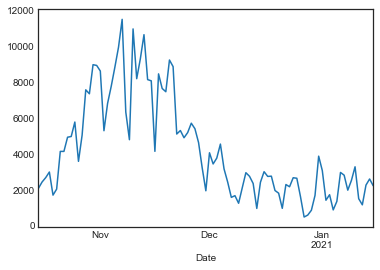

In [18]:
df_severity_hit.xs('Lombardy', level='Regione')['nuovi_positivi'].plot()

In [19]:
col_titles = ['Daily ICU', 'Daily cases', 'Daily deaths']
fig = make_subplots(vertical_spacing = 0.01, horizontal_spacing = 0.1, rows=1, cols=len(cols_to_show), \
                    shared_xaxes=True, shared_yaxes=False, row_titles=[''], column_titles=[])#subplot_titles=subplot_titles)

colors = px.colors.qualitative.Dark24

for i, col in enumerate(cols_to_show):
    y_vals = df_severity_hit[col]*(1000/df_severity_hit['Inhabitants'])
    #p_val_min, p_val_max = y_vals.quantile(.01), y_vals.quantile(.99)
    #y_vals = y_vals.loc[(p_val_min<y_vals)&(y_vals<p_val_max)]
    #y_vals = y_vals.transform(lambda x: (x-x.mean())/x.std(ddof=1))

    fig.add_trace(go.Box(
        y=y_vals,
        x=df_severity_hit.index.get_level_values('Regione'),
        name=col_titles[i],
        marker_color=colors[i],
        boxpoints=False
    ), row=1, col=i+1)


#fig.update_yaxes(range=[-2, 4])


fig.update_layout(title="", 
                  height=650, width=910, margin=dict(
            l=0,
            r=0,
            b=60,
            t=20,
            pad=0
        ),
        legend = dict(font = dict(size = 22, color = "black"), orientation="h"),
        #paper_bgcolor='rgba(255,0,0,255)',
        plot_bgcolor='rgba(0,0,0,0)'
        
)
'''
fig.update_layout( shapes=[
# unfilled rectange
go.layout.Shape(
type="rect",
xref="paper",
yref="paper",
x0=0,
y0=-0.1,
x1=1.05,
y1=1,
line={'width': 1, 'color': 'black'}), ])
'''
fig.update_xaxes(showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=17, color='black'), tickangle=20)
fig.update_yaxes(tickfont=dict(size=22, color='black'),showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)


fig.show()
fig.write_image('severity-hit.pdf')

# Forecasting

## Features
Our assumption is that the mobility feature (i.e., handover) gives information about the mobility level in the region at day t, while the mobile traffic features (download, upload and number of users) give information about the behaviour of the people at day t. Thanks to the fact that we are using data of one of the major providers, we are somehow sampling uniformely the population. At day t, we extract, for each KPI, the values:
- ${H_{t-1}, H_{t-2}, ..., H_{t-T_{F}}}$, being ${H_{t}}$ the handover at time t,
- ${N_{t-1}, N_{t-2}, ..., N_{t-T_{F}}}$, being ${N_{t}}$ the number of users at time t,
- ${D_{t-1}, H_{t-2}, ..., D_{t-T_{F}}}$, being ${D_{t}}$ the amount of traffic downloaded at time t,
- ${U_{t-1}, U_{t-2}, ..., U_{t-T_{F}}}$, being ${U_{t}}$ the amount of traffic uploaded at time t,
- ${R_{t-1}, R_{t-2}, ..., R_{t-T_{F}}}$, being ${R_{t}}$ the ${R_{t}}$ value at time t,
being T the number of backward steps.

## Methodology
As we approach a **multi-step forecasting problem**, we need to find a way to better exploit our data, and to build robust  models, that are robust to high step values. We implement **Walk forward validation**: at each time step t, we retrain the model; certain models have an aptitude for retrain, certain do not. For the formers, during validation at time step t we'll refit the model with a certain window; for the latters, we'll fit the model from scratch at each iteration, providing the values at t. We also implement **Independent-Value prediction** to handle the multi-step problem; this increases the complexity of the algorithm (we train a model for each future step), but guarantees much higher robustness to noise. Another problem that we may encounter, in particular for high step values, is the lack of smoothness in prediction. Also features may be not smooth, as they may suffer of oscillation, due to periodicity of events that affect them badly. An example is handover during weekends, that may change higly wrt week values. To smooth both features and predictions (when needed), we'll implement a **Kalman Filter**.

We'll consider each region ${R_{1}, ..., R_{R}}$ to be stand-alone; as for the ahead steps ${S_{1}, ..., S_{T}}$, we'll train a model for each. In the end, we'll have ${MxRxT}$, being M the number of models we validate.

We'll train M=5 models: Poly2 (i.e., polynomial regression with degree = 2 and with L2-regularization), Poly3 (i.e., polynomial regression with degree = 3 and with L2-regularization), RF (i.e., Random Forest with 100 estimators), XGB (i.e., XGBoost with 100 estimators) and DL (i.e., a deep learning model, consisting of an encoder decoder LSTM).

### Single region, Single model
![alt text](../preprocessing.png "")

In [20]:
name_current_save = 'results_v2_21_both'
path_results = "{}predictions/{}".format(saved, name_current_save)
path_results_mean = "{}_mean".format(path_results)

df_results_14 = pd.read_csv("{}.csv".format(path_results))
df_results_14['date'] = pd.to_datetime(df_results_14['date'])
df_results_14.set_index(['model', 'date', 'region', 'lag'], inplace=True)
df_results_14_mean = pd.read_csv("{}.csv".format(path_results_mean))
df_results_14_mean.set_index(['model', 'region', 'lag'], inplace=True)

lags_target = df_results_14.index.get_level_values('lag').unique()
regions = df_results_14.index.get_level_values('region').unique()
model_types = [m for m in df_results_14.index.get_level_values('model').unique()]
models_rename = {'Poly1': 'Poly1','Poly2': 'Poly2','Poly3': 'Poly3','RandomForest': 'RF','XGBoost': 'XGB','EncDecLSTM': 'DL'}

In [21]:
name_current_save = 'results_v1_7_both'
path_results = "{}predictions/{}".format(saved, name_current_save)
path_results_mean = "{}_mean".format(path_results)

df_results_7 = pd.read_csv("{}.csv".format(path_results))
df_results_7['date'] = pd.to_datetime(df_results_7['date'])
df_results_7.set_index(['model', 'date', 'region', 'lag'], inplace=True)
df_results_7 = pd.read_csv("{}.csv".format(path_results_mean))
df_results_7.set_index(['model', 'region', 'lag'], inplace=True)

lags_target = df_results_7.index.get_level_values('lag').unique()
regions = df_results_7.index.get_level_values('region').unique()
model_types = [m for m in df_results_7.index.get_level_values('model').unique()]

### Building results by farsightness
We use the predictions of each model to associate, to each pair (model, region), the results given a farsightness. The difference between lag and farsightness is that for lag L, we had samples associated to that ..., while for farsightness F we now train the model iteratively. Have a look at the following example: a vertical black line is associated to a day on which we start evaluating until the next line; during this period, we use F models, each associated to lag $l_1, l_2, ..., l_F$, that predict from one vertical line to the next.

In [22]:
max_farsightness = 30
lags_unique = [l for l in df_results_14.index.get_level_values('lag').unique() if l<=max_farsightness]
models_unique = df_results_14.index.get_level_values('model').unique()
regions_unique = df_results_14.index.get_level_values('region').unique()

In [23]:
def predict_for_lag(df_results, model, region, target_series, farsightness):
    #predict_with_lag = df_results.index.get_level_values('lag').max()
    df_results_current = df_results.xs(model, level='model').xs(region, level='region')
    dates = df_results_current.index.get_level_values('date').unique()
    lags_unique = df_results_current.index.get_level_values('lag').unique()
    num_dates = len(dates)
    predictions, index_predictions = [], []
    smoothened_predictions = []
    idx_dates = list(range(0, num_dates, farsightness))
    dates_to_return = dates[idx_dates]
    for idx_d in idx_dates:
        d = dates[idx_d]
        for idx_l, lag in enumerate([l for l in lags_unique if l <= farsightness]):
            try:
                current_prediction = df_results_current.xs(d + datetime.timedelta(days=lag), level='date')['prediction'].loc[lag:lag+1]
                #print("BELLA {}".format(current_prediction.values[0]))
                predictions.append(current_prediction.values[0])
                index_predictions.append(d + datetime.timedelta(days=lag))
                #smoothened_predictions = 
            except:
                # print("Non existing date for {}, {}".format(d, lag))
                # it means that we reached sine values that do not exist for ...
                pass
    target_series_current = target_series.xs(region, level='Regione')
    common_indices = target_series_current.index.intersection(target_series_current.index)
    
    target_series_current = target_series_current.loc[common_indices]
    
    df = pd.DataFrame({"prediction": predictions, "date": index_predictions})#.from_dict({"prediction": predictions, "date": index_predictions, "target": target_series_current})
    df.set_index('date', inplace=True)
    df['target'] = target_series_current
    df['farsightness']=farsightness
    df['model']=model
    df['region']=region
    return df, dates_to_return

In [24]:
#test_farsightness = 28#df_results.index.get_level_values('lag').max()
#test_df = predict_for_lag(df_results, 'EncDecLSTM', 'Lombardia', df_covid_predictions['R_mean'], test_farsightness)
dfs = []
dates_predictions = {}
for farsightness in lags_unique:
    print("{} ...".format(farsightness))
    for model in models_unique:
        for region in regions_unique:
            predictions, dates_sample = predict_for_lag(df_results_14, model, region, df_covid_predictions['R_mean'], farsightness)
            dfs.append(predictions)
            dates_predictions[farsightness] = dates_sample
df_results_new = pd.concat(dfs)
df_results_new = df_results_new.reset_index().set_index(['farsightness', 'model', 'region', 'date'])
df_results_new['error']=(df_results_new['prediction']-df_results_new['target']).abs()
df_results_new['error_2'] = df_results_new['error']**2

1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...


In [25]:
def build_df_results_groupped(df_results, col_prediction = 'prediction', col_error = 'error_2', col_rmse = 'rmse', col_r2 = 'r2', col_mape = 'mape'):
    df_results_to_group = df_results.dropna()
    try:
        groupped_df = df_results_to_group.groupby(level=['model', 'region', 'farsightness'])
    except:
        print("WARNING: not groupped")
        groupped_df = df_results_to_group
    df = pd.DataFrame()
    df[col_rmse] = np.sqrt(groupped_df[col_error].mean())
    
    #groupped_df = groupped_df.filter(lambda x: x['target'].isna().sum() <= 0)
    
    df[col_r2]=groupped_df.apply(lambda g: r2_score( g[col_prediction], g['target'] ))
    df[col_mape] = groupped_df.apply(lambda g: np.mean(np.abs((g['target'] - g['prediction']) / g['target'])) * 100)
    return df[[col_rmse, col_r2, col_mape]]

df_results_new_mean = build_df_results_groupped(df_results_new)

# Results

## Example of predictions with F=16

In [45]:
model='XGBoost'
region='Lombardia'
#ax = df_results_new.xs(farsightness_vals[0], level='farsightness').xs(model, level='model').xs(region, level='region')[['prediction']].plot(figsize=(16, 9))
fig = go.Figure()
colors = px.colors.sequential.Inferno

min_y, max_y = float("+inf"), float("-inf")
farsightness = 14

width_val = 1.5
width_low = 2
width_thick=3

#for idx_f, farsightness in enumerate([f for i, f in enumerate(farsightness_vals) if i % 3 == 2]):
to_plot = df_results_new.xs(farsightness, level='farsightness').xs(model, level='model').xs(region, level='region')[['prediction']]#.plot(ax=ax, figsize=(16, 9))
min_prediction_1, max_prediction_1 = to_plot['prediction'].min(), to_plot['prediction'].max()

lines_idx_1 = dates_predictions[farsightness]

fig.add_trace(
            go.Scatter(
            x=to_plot.index, y=to_plot['prediction'],
            line = dict(color=colors[3], width=width_val),
            marker_size=10,
            name='LH={}: prediction'.format(farsightness),
            showlegend=True
        )
    )
    
to_plot = df_results_new.xs(10, level='farsightness').xs(model, level='model').xs(region, level='region')[['target']]

min_target, max_target = to_plot['target'].min(), to_plot['target'].max()
fig.add_trace(
                go.Scatter(
                x=to_plot.index, y=to_plot['target'],
                line = dict(color='green', width=width_val, dash='dot'),
                marker_size=10,
                name='Target'.format(farsightness),
            )
        )



farsightness = 28

#for idx_f, farsightness in enumerate([f for i, f in enumerate(farsightness_vals) if i % 3 == 2]):
to_plot = df_results_new.xs(farsightness, level='farsightness').xs(model, level='model').xs(region, level='region')[['prediction']]#.plot(ax=ax, figsize=(16, 9))
min_prediction_2, max_prediction_2 = to_plot['prediction'].min(), to_plot['prediction'].max()

fig.add_trace(
            go.Scatter(
            x=to_plot.index, y=to_plot['prediction'],
            line = dict(color=colors[7], width=width_val, dash='dash'),
            marker_size=10,
            name='LH={}: prediction'.format(farsightness),
            showlegend=True
        )
    )

min_y, max_y = min(min_target, min_prediction_1, min_prediction_2), max(max_target, max_prediction_1, max_prediction_2)

for j, d in enumerate([d for i, d in enumerate(lines_idx_1) if i < len(lines_idx_1)-2]):
    fig.add_trace(go.Scatter(
        line = dict(color='rgba(0, 0, 0, 1)', width=width_low, dash='dot'),
        marker_size=1,
        x=[d, d],
        y=[min_y, max_y],
        name='T<sup>\'</sup><sub>L</sub>',
        showlegend=(j==0)
    ))

lines_idx_2 = dates_predictions[farsightness]
for j, d in enumerate([d for i, d in enumerate(lines_idx_2) if i < len(lines_idx_2)-1]):
    fig.add_trace(go.Scatter(
        line = dict(color='rgba(0, 0, 0, 1)', width=width_thick, dash='dash'),
        marker_size=1,
        x=[d, d],
        y=[min_y, max_y],
        showlegend=(j==0),
        name='T<sup>\'\'</sup><sub>L</sub>'
    ))
    
to_plot = df_results_new.xs(10, level='farsightness').xs(model, level='model').xs(region, level='region')[['target']]

'''
fig.add_trace(
                go.Scatter(
                x=to_plot.index, y=to_plot['target'],
                line = dict(color=colors[8], width=1, dash='dash'),
                marker_size=10,
                name='Target={}: prediction'.format(farsightness),
                showlegend=True
            )
        )
'''
fig.update_layout(title="", 
                  height=650, width=910, margin=dict(
            l=60,
            r=12,
            b=0,
            t=40,
            pad=0
        ),
        legend = dict(font = dict(size = 18, color = "black"), orientation="h"),
        plot_bgcolor='rgba(0,0,0,0)'
        
    )

fig.add_annotation(x=-0.07, y=.5,
        text="R<sub>t</sub>",
        showarrow=False,
                  yref='paper',xref='paper', font=dict(size=22, color='black'))

fig.update_xaxes(showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=20, color='black'))
fig.update_yaxes(tickfont=dict(size=22, color='black'),showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0)', zerolinewidth=1)
    
fig.show()
fig.write_image('independent-value-lh-16-32.pdf')

## Scatterplot RMSE and R2
To validate a model we'll use RMSE and R2. To achieve a reasonable farsightness, we'd need to check that these metrics will:
- keep resonable values (e.g.: ${R^{2}>0.8}$ and ${RMSE<0.1}$)
- not vary much when updating the lag value

These properties would allow to be able to achieve farsightness with a reasonable error during forecasting. So, every model will need to respect those properties to be considered suitable for the task.

In [74]:
# TODO fixed a region and a lag value, compare RMSE and R2 for different features in input
# TODO show execution time of these models
name_current_save_7 = 'results_v1_7_both'
name_current_save_1 = 'results_v1_1_both'
name_current_save_14 = 'results_v1_14_both'
name_current_save_21 = 'results_v1_21_both'


def get_results_and_time(path, region=None, model_name=None):
    path_results = "{}predictions/{}".format(saved, path)
    path_results_mean = "{}_mean".format(path_results)

    df_results = pd.read_csv("{}.csv".format(path_results))
    
    df_results['date'] = pd.to_datetime(df_results['date'])
    df_results.set_index(['model', 'date', 'region', 'lag'], inplace=True)
    
    if region is not None:
        df_results = df_results.loc[df_results.index.get_level_values('region')==region]
        
    if model_name is not None:
        df_results = df_results.loc[df_results.index.get_level_values('model')==model_name]
    
    lags_unique = [l for l in df_results.index.get_level_values('lag').unique() if l <= max_farsightness]
    models_unique = df_results.index.get_level_values('model').unique()
    regions_unique = df_results.index.get_level_values('region').unique()
    
    dfs = []
    dates_predictions = {}
    for farsightness in lags_unique:  
        print("{} ...".format(farsightness))
        for model in models_unique:
            for region in regions_unique:
                predictions, dates_sample = predict_for_lag(df_results, model, region, df_covid_predictions['R_mean'], farsightness)
                dfs.append(predictions)
                dates_predictions[farsightness] = dates_sample
    # TODO cambiare per mostrare anche il deltaT
    df_results_new = pd.concat(dfs)
    df_results_new = df_results_new.reset_index().set_index(['farsightness', 'model', 'region', 'date'])
    df_results_new['error']=(df_results_new['prediction']-df_results_new['target']).abs()
    df_results_new['error_2'] = df_results_new['error']**2
    
    df_results_new_mean = build_df_results_groupped(df_results_new)
    
    return df_results_new, df_results_new_mean

df_results_1, df_results_mean_1 = get_results_and_time(name_current_save_1)
df_results_7, df_results_mean_7 = get_results_and_time(name_current_save_7)
df_results_14, df_results_mean_14 = get_results_and_time(name_current_save_14)
df_results_21, df_results_mean_21 = get_results_and_time(name_current_save_21)

In [27]:
df_results_mean_1.xs('Lombardia', level='region').groupby(level='model').mean().mape

model
Poly1      8.678859
Poly2      6.789761
Poly3      5.374867
XGBoost    6.413607
Name: mape, dtype: float64

In [28]:
df_results_mean_7.xs('Lombardia', level='region').groupby(level='model').mean().mape

model
Poly1      6.732521
Poly2      3.210449
Poly3      2.240908
XGBoost    5.779194
Name: mape, dtype: float64

In [29]:
df_results_mean_14.xs('Lombardia', level='region').groupby(level='model').mean().mape

model
Poly1      5.302582
Poly2      1.935060
Poly3      1.377750
XGBoost    5.218656
Name: mape, dtype: float64

In [30]:
df_results_mean_21.xs('Lombardia', level='region').groupby(level='model').mean().mape

model
Poly1      4.260263
Poly2      1.821442
Poly3      1.499558
XGBoost    4.879318
Name: mape, dtype: float64

In [31]:
# TODO ora tempo di esecuzione
import pickle

def get_exec_time(path):
    path_results = "{}predictions/{}".format(saved, path)
    path_results_to_time_save = "{}_time_wfval".format(path_results)
    
    time_dict = pickle.load(open(path_results_to_time_save, "rb" ))
    
    dict_vals = []
    region = "Lombardia"
    for model in time_dict.keys():
        exec_times_dict = time_dict[model][region]
        exec_time = 0
        for lookahead in exec_times_dict.keys():
            exec_time += exec_times_dict[lookahead]
        dict_vals.append({'region': region, 'model': model, 'effort': exec_time})
    
    return pd.DataFrame(dict_vals)

df_time_1 = get_exec_time(name_current_save_1)
df_time_7 = get_exec_time(name_current_save_7)
df_time_14 = get_exec_time(name_current_save_14)
df_time_21 = get_exec_time(name_current_save_21)


In [54]:
df_time_1

region    model     effort
0  Lombardia    Poly1   8.162854
1  Lombardia    Poly2   9.236143
2  Lombardia    Poly3  13.188605
3  Lombardia  XGBoost  82.471953

In [55]:
df_time_7

region    model      effort
0  Lombardia    Poly1    9.336354
1  Lombardia    Poly2   14.404696
2  Lombardia    Poly3   33.076577
3  Lombardia  XGBoost  110.138678

In [56]:
df_time_14

region    model      effort
0  Lombardia    Poly1   10.326588
1  Lombardia    Poly2   20.362536
2  Lombardia    Poly3  151.241152
3  Lombardia  XGBoost  107.485792

In [57]:
df_time_21

region    model      effort
0  Lombardia    Poly1    9.327904
1  Lombardia    Poly2   25.200587
2  Lombardia    Poly3  392.418923
3  Lombardia  XGBoost  132.811811

In [43]:
# scatterplot of rmse
subplot_titles = ["", ""]
from plotly.validators.scatter.marker import SymbolValidator
#fig = make_subplots(specs=[{"secondary_y": True}], rows=len(models_constructors), shared_xaxes=True, shared_yaxes=True, subplot_titles=subplot_titles)
#fig=make_subplots(rows=len(models_constructors), shared_xaxes=True, shared_yaxes=True, subplot_titles=subplot_titles, specs=[[{"secondary_y": True}]])

#specs=[[[{"secondary_y": True}]] * len(model_types)]
raw_symbols = SymbolValidator().values
symbols = []
for i in range(0,len(raw_symbols),3):
    symbols.append(raw_symbols[i])

colors = px.colors.sequential.Inferno

max_lag = min(df_results_new_mean.index.get_level_values('farsightness').max(), max_farsightness)
regions_to_show = [r for r in regions if r=='Lombardia']

for random_region in regions_to_show:
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=False, subplot_titles=subplot_titles, vertical_spacing = 0.05, horizontal_spacing = 0.05)
    for idx_model, model_name in enumerate([m for m in model_types if "2" not in m]):
        '''
        if model_name == "Poly1" or model_name == "XGB":
            t_f = 21
            df_mean = df_results_mean_21
        else:
            t_f = 14
            df_mean = df_results_mean_14
        '''
        t_f = 14
            
        df_plot = df_results_new_mean.xs(model_name, level='model').xs(random_region, level='region').reset_index().set_index('farsightness')
        col_rmse, col_r2 = 'mape', 'r2'
        rmse_vals, r2_vals = df_plot[col_rmse], df_plot[col_r2]
        
        '''
        y_mean = rmse_vals.mean()

        fig.add_trace(
                go.Scatter(
                x=[max_lag+1], y=[y_mean],
                name="{}".format(model_name),
                marker_symbol='star-diamond', 
                line = dict(color=colors[idx_model], width=2),
                marker_color=colors[idx_model],
                marker_size=10,
                showlegend=True
            ),
            row=1, col=1
        )
        '''

        fig.add_trace(
            go.Scatter(x=rmse_vals.index, y=rmse_vals, name="{}".format(models_rename[model_name]), 
                        marker_symbol=raw_symbols[idx_model*12+2], 
                        line = dict(color=colors[idx_model*2+1], width=3),
                        marker_color=colors[idx_model],
                        showlegend=True,
                      marker_size=8),
            row=1, col=1
        )
        
        '''
        model = LinearRegression()
        x_vals = rmse_vals.index.to_numpy().reshape(-1, 1)
        y_vals = rmse_vals.to_numpy().reshape(-1, 1)
        model.fit(x_vals, y_vals)
        
        #x_range = np.linspace(X.min(), X.max(), 100)
        y_range = model.predict(x_vals)
        
        fig.add_trace(
            go.Scatter(x=rmse_vals.index, y=y_range.flatten(), name="{} mean".format(models_rename[model_name]), 
                        marker_symbol=raw_symbols[idx_model*12+2], 
                        line = dict(color=colors[idx_model], width=3, dash='dash'),
                        marker_color=colors[idx_model],
                        showlegend=False,
                      marker_size=8),
            row=1, col=1
        )
        '''


    #fig.update_yaxes(row=1, col=1, range=[1, 8])
    
    #fig.update_yaxes(range=[-1, +1])
    fig.update_layout(title="", height=660, width=910, margin=dict(
            l=0,
            r=0,
            b=0,
            t=0,
            pad=0
        ),
        #tickfont = dict(size=20),
        legend = dict(
            bordercolor="Black",
            borderwidth=1,
            font = dict(size = 24, color = "black"), orientation="v",y=.98, x=0.85),
        plot_bgcolor='rgba(0,0,0,0)'
    )
    '''
    fig.add_annotation(x=1.03, y=-0.13,
            text="T<sub>L</sub>",
            showarrow=False,
                      yref='paper',xref='paper', font=dict(size=32, color='black'))
    
    fig.add_annotation(x=0.01, y=1.11,
            text="MAPE [%]",
            showarrow=False,
                      yref='paper',xref='paper', font=dict(size=32, color='black'))
    '''
    fig.update_xaxes(title='T<sub>L</sub>',title_standoff=15, titlefont=dict(size=26, color='black'),automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=22, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
    #fig.update_yaxes(range=(1, 8), title='MAPE [%]', title_standoff=20, titlefont=dict(size=26, color='black'), tickfont=dict(size=22, color='black'), automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)
    

    fig.write_image("{}_mape.pdf".format(random_region))
    
    fig.show()

In [44]:
for random_region in regions_to_show:
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=False, subplot_titles=subplot_titles, vertical_spacing = 0.05, horizontal_spacing = 0.05)
    for idx_model, model_name in enumerate([m for m in model_types if "2" not in m]):
        
        '''
        if model_name == "Poly1" or model_name == "XGB":
            t_f = 21
            df_mean = df_results_mean_21
        else:
            t_f = 14
            df_mean = df_results_mean_14
        '''
        t_f = 14
            
        df_plot = df_results_new_mean.xs(model_name, level='model').xs(random_region, level='region').reset_index().set_index('farsightness')
        
        #df_plot = df_results_mean_21.xs(model_name, level='model').xs(random_region, level='region').reset_index().set_index('farsightness')
        col_rmse, col_r2 = 'mape', 'r2'
        rmse_vals, r2_vals = df_plot[col_rmse], df_plot[col_r2]

        '''
        y_mean = r2_vals.mean()

        fig.add_trace(
                go.Scatter(
                x=[max_lag+1], y=[y_mean],
                name="{}".format(model_name),
                marker_symbol='star-diamond', 
                line = dict(color=colors[idx_model], width=2),
                marker_color=colors[idx_model],
                marker_size=10,
                showlegend=True
            ),
            row=1, col=1
        )
        '''

        fig.add_trace(
            go.Scatter(x=r2_vals.index, y=r2_vals, name="{}".format(models_rename[model_name]), 
                        marker_symbol=raw_symbols[idx_model*12+2], 
                        line = dict(color=colors[idx_model], width=3),
                        marker_color=colors[idx_model],
                        showlegend=True,
                      marker_size=8),
            row=1, col=1
        )
        
        '''
        model = LinearRegression()
        x_vals = r2_vals.index.to_numpy().reshape(-1, 1)
        y_vals = r2_vals.to_numpy().reshape(-1, 1)
        model.fit(x_vals, y_vals)
        
        #x_range = np.linspace(X.min(), X.max(), 100)
        y_range = model.predict(x_vals)
        
        fig.add_trace(
            go.Scatter(x=r2_vals.index, y=y_range.flatten(), name="{} mean".format(models_rename[model_name]), 
                        marker_symbol=raw_symbols[idx_model*12+2], 
                        line = dict(color=colors[idx_model], width=3, dash='dash'),
                        marker_color=colors[idx_model],
                        showlegend=False,
                      marker_size=8),
            row=1, col=1
        )
        '''


    #fig.update_yaxes(row=1, col=1, range=[.4, 1])
    
    #fig.update_yaxes(range=[-1, +1])
    fig.update_layout(title="", height=600, width=900, margin=dict(
            l=0,
            r=20,
            b=0,
            t=50,
            pad=0
        ),
        legend = dict(
            bordercolor="Black",
            borderwidth=1,
            font = dict(size = 24, color = "black"), orientation="v",y=.03, x=0.79),
        #tickfont = dict(size=20),
        plot_bgcolor='rgba(0,0,0,0)'
    )

    '''
    fig.add_annotation(x=1.03, y=-0.13,
            text="T<sub>L</sub>",
            showarrow=False,
                      yref='paper',xref='paper', font=dict(size=32, color = "black"))
    '''
    fig.update_yaxes(title='R<sup>2</sup>', title_standoff=20, titlefont=dict(size=32, color='black'), tickfont=dict(size=30, color = "black"), automargin=True, showline=True,mirror=True, linewidth=1,linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)
    fig.update_xaxes(title='T<sub>L</sub>',title_standoff=15, titlefont=dict(size=32, color='black'),automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=30, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)

    fig.show()
    fig.write_image("{}_r2.pdf".format(random_region))

In [262]:
# TODO prendere output per i diversi: both, only_traffic, only_covid -> poly3
t_f = 14
scenarios = ['both', 'only_traffic', 'only_covid']
rename_scenarios = {"both": "Poly3-TC", "only_traffic": "Poly3-TO", "only_covid": "Poly3-CO"}
dfs = []
dfs_mean = []

region = 'Lombardia'
model_name = 'Poly3'
for scenario in scenarios:
    path = 'results_v1_{}_{}'.format(t_f, scenario)
    '''
    path_results = "{}predictions/{}".format(saved, path)
    path_results_mean = "{}_mean".format(path_results)

    df = pd.read_csv("{}.csv".format(path_results_mean))
    df.set_index(['model', 'region', 'lag'], inplace=True)
    '''
    df, df_mean = get_results_and_time(path, region, model_name)
    df = df.xs(('Poly3', 'Lombardia'), level=('model', 'region'))
    df_mean = df_mean.xs(('Poly3', 'Lombardia'), level=('model', 'region'))
    df['scenario'] = rename_scenarios[scenario]
    df_mean['scenario'] = rename_scenarios[scenario]
    dfs.append(df)
    dfs_mean.append(df_mean)
df_scenarios_input = pd.concat(dfs)
df_scenarios_input = df_scenarios_input.reset_index().set_index(['scenario', 'farsightness'])

df_scenarios_input_mean = pd.concat(dfs_mean)
df_scenarios_input_mean = df_scenarios_input_mean.reset_index().set_index(['scenario', 'farsightness'])

1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...
1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...
1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...


In [264]:
colors = px.colors.qualitative.Vivid

random_region = 'Lombardia'
regions_to_show = [r for r in regions if r==random_region]

scenarios = df_scenarios_input_mean.index.get_level_values('scenario').unique()

#for random_region in regions_to_show:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=False, subplot_titles=subplot_titles, vertical_spacing = 0.05, horizontal_spacing = 0.05)
scenarios = [scenarios[1], scenarios[2], scenarios[0]]
for idx_scenario, scenario in enumerate(scenarios):

    df_plot = df_scenarios_input_mean.xs(scenario, level='scenario').reset_index().set_index('farsightness')
    col_rmse, col_r2 = 'mape', 'r2'
    rmse_vals, r2_vals = df_plot[col_rmse], df_plot[col_r2]
    
    '''
    y_mean = rmse_vals.mean()

    fig.add_trace(
            go.Scatter(
            x=[max_lag+1], y=[y_mean],
            name="{}".format(scenario),
            marker_symbol='star-diamond', 
            line = dict(color=colors[idx_scenario], width=2),
            marker_color=colors[idx_scenario],
            marker_size=10,
            showlegend=False
        ),
        row=1, col=1
    )
    '''

    fig.add_trace(
        go.Scatter(x=rmse_vals.index, y=rmse_vals, name="{}".format(scenario), 
                    marker_symbol=raw_symbols[idx_scenario*12+2], 
                    line = dict(color=colors[idx_scenario], width=3),
                    marker_color=colors[idx_scenario],
                    showlegend=True,
                  marker_size=8),
        row=1, col=1
    )
    
    '''
    model = LinearRegression()
    x_vals = rmse_vals.index.to_numpy().reshape(-1, 1)
    y_vals = rmse_vals.to_numpy().reshape(-1, 1)
    model.fit(x_vals, y_vals)

    #x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_vals)

    fig.add_trace(
        go.Scatter(x=rmse_vals.index, y=y_range.flatten(), name="{} mean".format(scenario), 
                    marker_symbol=raw_symbols[idx_scenario*12+2], 
                    line = dict(color=colors[idx_scenario], width=3, dash='dash'),
                    marker_color=colors[idx_scenario],
                    showlegend=False,
                  marker_size=8),
        row=1, col=1
    )
    '''



#fig.update_yaxes(range=[-1, +1])
fig.update_layout(title="", height=600, width=900, margin=dict(
        l=0,
        r=20,
        b=0,
        t=50,
        pad=0
        ),
        legend = dict(
            bordercolor="Black",
            borderwidth=1,
            font = dict(size = 24, color = "black"), orientation="v",y=.99, x=0.79),
        
        
        plot_bgcolor='rgba(0,0,0,0)'
)

'''
fig.add_annotation(x=1.03, y=-0.13,
        text="T<sub>L</sub>",
        showarrow=False,
                  yref='paper',xref='paper', font=dict(size=32, color='black'))
'''
'''
fig.add_annotation(x=0.01, y=1.11,
        text="MAPE [%]",
        showarrow=False,
                  yref='paper',xref='paper', font=dict(size=32, color='black'))
'''
fig.update_xaxes(title='T<sub>L</sub>',title_standoff=15, titlefont=dict(size=32, color='black'),automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=30, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
fig.update_yaxes(title='MAPE [%]',range=(1,14),title_standoff=20, titlefont=dict(size=32, color='black'), tickfont=dict(size=30, color='black'), automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)
    
fig.show()
fig.write_image("{}_scenarios_mape.pdf".format(random_region))

In [47]:
ranges = [0, 7, 14, 21, 30]
df_scenarios_input_mean.groupby(['scenario', pd.cut(df_scenarios_input_mean.index.get_level_values('farsightness'), ranges)]).agg({'mape':'mean', 'r2':'max'})

#df_scenarios_input_mean

mape        r2
scenario                              
Poly3-CO (0, 7]     6.213878  0.913947
         (7, 14]    9.196815  0.519501
         (14, 21]  10.404327  0.425035
         (21, 30]   9.194448  0.637037
Poly3-TC (0, 7]     1.324684  0.989448
         (7, 14]    1.355207  0.989587
         (14, 21]   1.470060  0.989177
         (21, 30]   1.364761  0.987116
Poly3-TO (0, 7]     2.051337  0.978646
         (7, 14]    2.000406  0.975392
         (14, 21]   1.743481  0.984649
         (21, 30]   2.072978  0.977526

In [64]:
df_scenarios_input.index.get_level_values('scenario').unique()

Index(['Poly3-TC', 'Poly3-TO', 'Poly3-CO'], dtype='object', name='scenario')

In [244]:
# TODO prendere output per i diversi: both, only_traffic, only_covid -> poly3
t_f = 14
regions = ['Lombardia', 'Veneto', 'Lazio', 'Campania', 'Sardegna', 'Puglia']
#rename_scenarios = {"both": "BT", "only_traffic": "OT", "only_covid": "OC"}
dfs = []
dfs_mean = []

model_name = 'Poly3'

t_f, scenario = 14, 'both'
path = 'results_v1_{}_{}'.format(t_f, scenario)

df_regions, df_regions_mean = get_results_and_time(path, model_name=model_name)

1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...


<AxesSubplot:xlabel='date'>

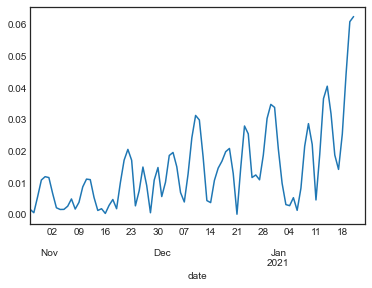

In [50]:
df_to_test = df_scenarios_input.xs((30, 'Poly3-TC'), level=('farsightness', 'scenario')).reset_index().set_index('date')
(np.abs(df_to_test['prediction']-df_to_test['target'])/df_to_test['target']).plot()

<AxesSubplot:xlabel='date'>

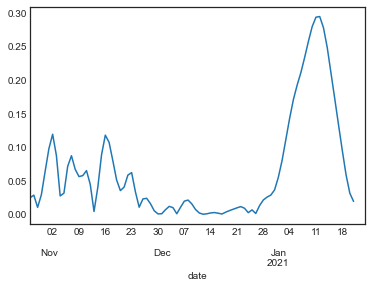

In [51]:
df_to_test = df_results_7.xs((30, 'Poly3', 'Veneto'), level=('farsightness', 'model', 'region')).reset_index().set_index('date')
(np.abs(df_to_test['prediction']-df_to_test['target'])/df_to_test['target']).plot()

In [247]:
df_mean

rmse        r2       mape scenario
model   farsightness                                        
Poly1   1             0.083252  0.640899   7.815411       CO
        2             0.092174  0.561761   8.645950       CO
        3             0.100773  0.472269   9.433237       CO
        4             0.108949  0.376197  10.188566       CO
        5             0.115773  0.281562  10.767083       CO
...                        ...       ...        ...      ...
XGBoost 26            0.150410 -0.763680  11.333599       CO
        27            0.154010 -0.899746  10.261134       CO
        28            0.157667 -0.981850  10.082648       CO
        29            0.145834 -0.507594   9.186440       CO
        30            0.133619 -0.156235   8.138280       CO

[120 rows x 4 columns]

In [260]:
colors = px.colors.qualitative.Dark24
regions_to_show = ['Lombardia', 'Puglia', 'Veneto', 'Sardegna']#df_regions_mean.index.get_level_values('region').unique()

regions_rename={'Lombardia': 'Lombardy', 'Puglia': 'Apulia', 'Veneto': 'Veneto', 'Sardegna': 'Sardinia'}

fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=False, subplot_titles=subplot_titles, vertical_spacing = 0.05, horizontal_spacing = 0.05)
for idx_region, random_region in enumerate(regions_to_show):
    model_name='Poly3'
    #for idx_model, model_name in enumerate(model_types):

    '''
        if model_name == "Poly1" or model_name == "XGB":
            t_f = 21
            df_mean = df_results_mean_21
        else:
            t_f = 14
            df_mean = df_results_mean_14
        '''
    t_f = 14

    df_plot = df_regions_mean.xs(model_name, level='model').xs(random_region, level='region').reset_index().set_index('farsightness')

    #df_plot = df_results_mean_21.xs(model_name, level='model').xs(random_region, level='region').reset_index().set_index('farsightness')
    col_rmse, col_r2 = 'mape', 'r2'
    rmse_vals, r2_vals = df_plot[col_rmse], df_plot[col_r2]
    '''
    y_mean = rmse_vals.mean()
    
    fig.add_trace(
            go.Scatter(
            x=[max_lag+1], y=[y_mean],
            name="{}".format(regions_rename[random_region]),
            marker_symbol='star-diamond', 
            line = dict(color=colors[idx_region], width=2),
            marker_color=colors[idx_region],
            marker_size=10,
            showlegend=True
        ),
        row=1, col=1
    )
    '''
    fig.add_trace(
        go.Scatter(x=rmse_vals.index, y=rmse_vals, name="{}".format(regions_rename[random_region]), 
                    marker_symbol=raw_symbols[idx_region*12+2], 
                    line = dict(color=colors[idx_region], width=3),
                    marker_color=colors[idx_region],
                    showlegend=True,
                  marker_size=8),
        row=1, col=1
    )
    '''
    model = LinearRegression()
    x_vals = rmse_vals.index.to_numpy().reshape(-1, 1)
    y_vals = rmse_vals.to_numpy().reshape(-1, 1)
    model.fit(x_vals, y_vals)

    #x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_vals)

    fig.add_trace(
        go.Scatter(x=rmse_vals.index, y=y_range.flatten(), name="{} mean".format(models_rename[model_name]), 
                    marker_symbol=raw_symbols[idx_region*12+2], 
                    line = dict(color=colors[idx_region], width=3, dash='dash'),
                    marker_color=colors[idx_model],
                    showlegend=False,
                  marker_size=8),
        row=1, col=1
    )
    '''


    fig.update_yaxes(row=1, col=1, range=[.8, 3.2])
    
    fig.update_layout(title="", height=650, width=910, margin=dict(
            l=0,
            r=0,
            b=0,
            t=40,
            pad=0
        ),
        #tickfont = dict(size=20),
        
        legend = dict(
            bordercolor="Black",
            borderwidth=1,
            font = dict(size = 21, color = "black"), orientation="v",y=.99, x=0.81),
        plot_bgcolor='rgba(0,0,0,0)'
    )
    
    #fig.update_xaxes(automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=20, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
    fig.update_yaxes(title='MAPE [%]', tickfont=dict(size=20, color='black'), automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)
    fig.update_yaxes(titlefont=dict(size=26, color='black'))
    fig.update_xaxes(title='T<sub>L</sub>',title_standoff=15,automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=30, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
    fig.update_xaxes(titlefont=dict(size=26, color='black'))
    #fig.update_xaxes(automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=22),tickprefix="<b>",ticksuffix ="</b><br>", gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
    #fig.update_yaxes(tickfont=dict(size=22), automargin=True, showline=True,mirror=True, linewidth=1,tickprefix="<b>",ticksuffix ="</b><br>", linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)


fig.show()
fig.write_image("more_regions_mape.pdf")

## Boxplot RMSE and R2
For each lag, we show the distribution of R2 and RMSE of three models: Poly3+KF, XGBoost+KF, EncDecLSTM+KF. Goal is to
- compare approaches of polynomial vs DL vs XGBoost
- give an idea of how to do validation

In [53]:
col_r2, col_rmse = 'r2', 'rmse'
do_kalman = False

if do_kalman:
    col = 'best_{}'.format(col)

    
specs=[[{"type": "box"}, {"type": "box"}]]

fig = make_subplots(specs=specs, rows=1, cols=2, subplot_titles=["RMSE", "R2"])
#df_plot = df_results_mean.reset_index()
models_to_consider = model_types#[m for m in model_types if "orest" not in m and 'oly2' not in m]

df_plot = df_results_new_mean#.loc[(df_results_new_mean.index.get_level_values('farsightness').isin(lags_to_show))
                              #&(df_results_new_mean.index.get_level_values('model').isin(models_to_consider))]

df_plot = df_plot.reset_index()
#df_plot['model'] = df_plot['model'].apply(lambda x: models_rename[x])
df_plot = df_plot.set_index(['model','region','farsightness'])
means = df_plot.groupby(by=["farsightness", "model"]).mean()[col_rmse]

'''
df_plot = df_results_mean_ma.loc[(df_results_mean_ma.index.get_level_values('lag')<max_lag_to_show)
                              &(df_results_mean_ma.index.get_level_values('model').isin(models_to_consider))]
lags_to_show = df_plot.index.get_level_values('lag').unique()
df_plot = df_plot.reset_index()
df_plot['model'] = df_plot['model'].apply(lambda x: models_rename[x]+"+KF")
df_plot = df_plot.set_index(['model','region','lag'])
means = df_plot.groupby(by=["lag", "model"]).mean()[col_rmse]
'''

df_columns_rmse = pd.DataFrame()
df_columns_rmse['value'] = df_plot[col_rmse]
q1, q2 = df_columns_rmse["value"].quantile(0.01), df_columns_rmse["value"].quantile(0.99)
df_columns_rmse = df_columns_rmse[(q1 < df_columns_rmse["value"])&(df_columns_rmse['value'] < q2)]
df_columns_rmse['type']='rmse'
df_columns_r2 = pd.DataFrame()
df_columns_r2['value'] = df_plot[col_r2]
q1, q2 = df_columns_r2["value"].quantile(0.05), df_columns_r2["value"].quantile(0.95)
df_columns_r2 = df_columns_r2[(q1 < df_columns_r2["value"])&(df_columns_r2['value'] < q2)]
df_columns_r2['type']='r2'
df_columns = pd.concat([df_columns_rmse, df_columns_r2])


fig = px.box(df_columns.reset_index(), x="farsightness", y='value', color="model",labels={'value':'', 'type':'Validation'}, facet_col='type', range_y=[[0,1], [0, 5]])

# Add figure title
fig.update_layout(
    title_text="Boxplot errors",
    boxmode='group',
    height=500, width=1000, margin=dict(
            l=0,
            r=0,
            b=50,
            t=30,
            pad=0
        ),
        legend = dict(font = dict(size = 10, color = "black"), orientation="h",
        yanchor="top")
)
fig.update_yaxes(matches=None)
#fig.update_yaxes(range=[0, 1])
#fig.update_yaxes(range=[0, .14], row=1, col=1)
#fig.update_yaxes(range=[0.5, 1], row=1, col=2)

fig.show()

In [271]:
# TODO prendere output per i diversi: both, only_traffic, only_covid -> poly3
t_f = 14
scenarios = ['both', 'only_traffic', 'only_covid']
rename_scenarios = {"both": "TC", "only_traffic": "TO", "only_covid": "CO"}
dfs = []
dfs_mean = []

region = 'Lombardia'
for scenario in scenarios:
    path = 'results_v1_{}_{}'.format(t_f, scenario)
    df, df_mean = get_results_and_time(path, region)
    df = df.xs('Lombardia', level='region')
    df_mean = df_mean.xs('Lombardia', level='region')
    df['scenario'] = rename_scenarios[scenario]
    df_mean['scenario'] = rename_scenarios[scenario]
    dfs.append(df)
    dfs_mean.append(df_mean)
df_scenarios_input = pd.concat(dfs)
df_scenarios_input = df_scenarios_input.reset_index().set_index(['model', 'scenario', 'farsightness'])

df_scenarios_input_mean = pd.concat(dfs_mean)
df_scenarios_input_mean = df_scenarios_input_mean.reset_index().set_index(['model', 'scenario', 'farsightness'])

1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...
1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...
1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...
28 ...
29 ...
30 ...


In [30]:
fig = go.Figure()
df_filtered = df_scenarios_input_mean.loc[df_scenarios_input_mean.index.get_level_values('farsightness').isin([7, 14, 21, 28])]
#df_filtered['first_group']=df_filtered.reset_index().apply(lambda x: "{}-{}".format(x['farsightness'], x['scenario']), axis=1)
dict_sort = {'CO': 1, 'TO': 2, 'TC': 3}
df_filtered = df_filtered.loc[df_filtered.index.get_level_values('model').isin(['Poly1', 'Poly3', 'XGBoost'])]
df_filtered['scenario_order'] = df_filtered.reset_index().apply(lambda x: dict_sort[x['scenario']], axis=1)
df_filtered = df_filtered.sort_values(by='scenario_order', ascending=False)
#df_filtered = df_filtered.set_index(['model', 'farsightness', 'scenario'])

def idx(n_s, n_m, idx_model, idx_scenario, idx_farsightness):
    return (idx_farsightness*n_s*n_m+idx_farsightness*2)+idx_scenario*n_m+((idx_farsightness*n_s+idx_scenario))*1+idx_model

unique_scenarios, unique_models = df_filtered.index.get_level_values('scenario').unique(), df_filtered.index.get_level_values('model').unique()
unique_scenarios = ['CO', 'TO', 'TC']

idx_scenarios, idx_models, idx_farsightness = {}, {}, {}
step = 1
for i, scenario in enumerate(unique_scenarios):
    idx_scenarios[scenario] = step*i
    
for i, model in enumerate(unique_models):
    idx_models[model] = step*i
step = 1
for i, farsightness in enumerate(df_filtered.index.get_level_values('farsightness').unique()):
    idx_farsightness[farsightness] = step*i

n_s, n_m = len(unique_scenarios), len(unique_models)

#color_models = {}

model_shown = {}

colors = px.colors.sequential.Inferno

for scenario, model in itertools.product(*[unique_scenarios, unique_models]):
    df_plot = df_filtered.xs((model, scenario), level=('model', 'scenario'))
    
    for f in df_plot.index.unique():
        fig.add_trace(
            go.Bar(
                x=[idx(n_s, n_m, idx_models[model], idx_scenarios[scenario], idx_farsightness[f])],
                y=[df_plot.loc[f].mape],
                name="{}".format(model),
                marker_color=colors[idx_models[model]*2+3],
                showlegend=model not in model_shown
            )
        )
        model_shown[model]=True

fig.update_layout(barmode='group')

#fig.update_yaxes(range=[.8, 6.2])
    
fig.update_layout(title="", height=650, width=910, margin=dict(
        l=0,
        r=0,
        b=80,
        t=0,
        pad=0
    ),
    plot_bgcolor='rgba(0,0,0,0)'
)

#fig.update_xaxes(automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=20, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
fig.update_yaxes(title='MAPE [%]', tickfont=dict(size=20, color='black'), automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)
fig.update_yaxes(titlefont=dict(size=26, color='black'))
fig.update_xaxes(title='T<sub>L</sub>',title_standoff=55,automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=30, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
fig.update_xaxes(titlefont=dict(size=26, color='black'))

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [],
        ticktext = []
    ),
    
        legend = dict(
            bordercolor="Black",
            borderwidth=1,
            font = dict(size = 24, color = "black"), orientation="v",y=.99, x=0.815),
)


fig.add_annotation(x=0.08, y=-0.15,
    text="7",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.36, y=-0.15,
    text="14",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.63, y=-0.15,
    text="21",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.91, y=-0.15,
    text="28",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.01, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.08, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.15, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))



fig.add_annotation(x=0.27, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.36, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.44, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))



fig.add_annotation(x=0.555, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.63, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.725, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))



fig.add_annotation(x=0.835, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.91, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.99, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.show()

fig.write_image('grouped_scenarios_mape_no_poly2.pdf')

NameError: name 'df_scenarios_input_mean' is not defined

In [280]:
fig = go.Figure()
df_filtered = df_scenarios_input_mean.loc[df_scenarios_input_mean.index.get_level_values('farsightness').isin([7, 14, 21, 28])]
df_filtered['first_group']=df_filtered.reset_index().apply(lambda x: "{}-{}".format(x['farsightness'], x['scenario']), axis=1)
#df_filtered = df_filtered.set_index(['model', 'farsightness', 'scenario'])

def idx(n_s, n_m, idx_model, idx_scenario, idx_farsightness):
    return (idx_farsightness*n_s*n_m+idx_farsightness*2)+idx_scenario*n_m+((idx_farsightness*n_s+idx_scenario))*1+idx_model

idx_scenarios, idx_models, idx_farsightness = {}, {}, {}
step = 1
for i, scenario in enumerate(df_filtered.index.get_level_values('scenario').unique()):
    idx_scenarios[scenario] = step*i
    
for i, model in enumerate(df_filtered.index.get_level_values('model').unique()):
    idx_models[model] = step*i
step = 1
for i, farsightness in enumerate(df_filtered.index.get_level_values('farsightness').unique()):
    idx_farsightness[farsightness] = step*i

unique_scenarios, unique_models = df_scenarios_input_mean.index.get_level_values('scenario').unique(), df_scenarios_input_mean.index.get_level_values('model').unique()
n_s, n_m = len(unique_scenarios), len(unique_models)

#color_models = {}

model_shown = {}

for scenario, model in itertools.product(*[unique_scenarios, unique_models]):
    df_plot = df_filtered.xs((model, scenario), level=('model', 'scenario'))
    
    for f in df_plot.index.unique():
        fig.add_trace(
            go.Bar(
                x=[idx(n_s, n_m, idx_models[model], idx_scenarios[scenario], idx_farsightness[f])],
                y=[df_plot.loc[f].r2],
                name="{}".format(model),
                marker_color=colors[idx_models[model]],
                showlegend=model not in model_shown
            )
        )
        model_shown[model]=True

fig.update_layout(barmode='group')

#fig.update_yaxes(range=[.8, 6.2])
    
fig.update_layout(title="", height=650, width=910, margin=dict(
        l=0,
        r=0,
        b=0,
        t=40,
        pad=0
    ),
    #tickfont = dict(size=20),
    plot_bgcolor='rgba(0,0,0,0)'
)

#fig.update_xaxes(automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=20, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
fig.update_yaxes(title='R<sup>2</sup>', tickfont=dict(size=20, color='black'), automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', gridcolor='rgba(0,0,0,0.02)', gridwidth=1, zerolinecolor='rgba(0,0,0,0.05)', zerolinewidth=1)
fig.update_yaxes(titlefont=dict(size=26, color='black'))
fig.update_xaxes(title='T<sub>L</sub>',title_standoff=55,automargin=True, showline=True,mirror=True, linewidth=1, linecolor='black', tickfont=dict(size=30, color='black'), gridcolor='rgba(0,0,0,0.02)', gridwidth=1)
fig.update_xaxes(titlefont=dict(size=26, color='black'))

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [],
        ticktext = []
    ),
    margin=dict(
        b=40
    ),
    
    legend = dict(
        bordercolor="Black",
        borderwidth=1,
        font = dict(size = 24, color = "black"), orientation="v",y=.01, x=0.75),
)


fig.add_annotation(x=0.08, y=-0.15,
    text="7",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.36, y=-0.15,
    text="14",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.63, y=-0.15,
    text="21",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.91, y=-0.15,
    text="28",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))


fig.add_annotation(x=0.01, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.08, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.15, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))



fig.add_annotation(x=0.27, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.36, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.44, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))



fig.add_annotation(x=0.555, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.63, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.725, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))



fig.add_annotation(x=0.835, y=-0.08,
    text="TC",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.91, y=-0.08,
    text="TO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.add_annotation(x=0.99, y=-0.08,
    text="CO",
    showarrow=False,
              yref='paper',xref='paper', font=dict(size=22,color='black'))

fig.show()

fig.write_image('grouped_scenarios_r2.pdf')

<ipython-input-280-0adf62da7b8a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
print(idx_farsightness)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29}


In [149]:
df_filtered.head()

rmse        r2      mape first_group
model farsightness scenario                                          
Poly1 7            TC        0.057306  0.848423  5.268473         NaN
      14           TC        0.056059  0.835847  4.958882         NaN
      21           TC        0.064692  0.811945  6.427392         NaN
      28           TC        0.060042  0.816016  5.375464         NaN
Poly2 7            TC        0.022334  0.973152  1.846282         NaN

In [ ]:
import seaborn as sns
sns.factorplot(x='class', y='', hue='model', data=df_scenarios_input_mean, kind='bar')